# Facial and Speech Emotion Recognition Project

## 1. Project Setup and Dependencies

In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 # For image processing (Facial Emotion)
import librosa # For audio processing (Speech Emotion)
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, LSTM, Reshape
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns # For Confusion Matrix visualization

## 2. Facial Emotion Recognition (FER) Module

### 2.1. Data Loading and Preprocessing (FER2013)

In [2]:
# Emotion labels for FER2013
FER_EMOTION_LABELS = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
IMG_SIZE = 48
NUM_FER_CLASSES = len(FER_EMOTION_LABELS)

def load_fer2013_data(data_path="FER2013/fer2013.csv"):
    """
    Loads and preprocesses the FER2013 dataset.
    """
    print(f"Attempting to load FER2013 data from: {data_path}")
    try:
        # Load the dataset (assuming a CSV structure common for FER2013)
        data = pd.read_csv(data_path)
        
        # Split data into training, validation, and test sets based on the 'Usage' column
        train_data = data[data['Usage'] == 'Training']
        val_data = data[data['Usage'] == 'PublicTest']
        test_data = data[data['Usage'] == 'PrivateTest']
        
        # Function to process pixel strings into numpy arrays
        def process_pixels(df):
            X = np.array([np.fromstring(pixel, dtype=int, sep=' ').reshape((IMG_SIZE, IMG_SIZE, 1)) for pixel in df['pixels']])
            X = X / 255.0 # Normalize
            y = to_categorical(df['emotion'], num_classes=NUM_FER_CLASSES)
            return X, y

        X_train, y_train = process_pixels(train_data)
        X_val, y_val = process_pixels(val_data)
        X_test, y_test = process_pixels(test_data)
        
        print(f"FER2013 Data Loaded: Train={len(X_train)}, Validation={len(X_val)}, Test={len(X_test)}")
        return X_train, y_train, X_val, y_val, X_test, y_test
    
    except FileNotFoundError:
        print("FER2013 data file not found. Generating synthetic data for model structure testing.")
        # Generate synthetic data for demonstration and structure testing
        X_train = np.random.rand(1000, IMG_SIZE, IMG_SIZE, 1).astype('float32')
        y_train = to_categorical(np.random.randint(0, NUM_FER_CLASSES, 1000), num_classes=NUM_FER_CLASSES)
        X_val = np.random.rand(100, IMG_SIZE, IMG_SIZE, 1).astype('float32')
        y_val = to_categorical(np.random.randint(0, NUM_FER_CLASSES, 100), num_classes=NUM_FER_CLASSES)
        X_test = np.random.rand(100, IMG_SIZE, IMG_SIZE, 1).astype('float32')
        y_test = to_categorical(np.random.randint(0, NUM_FER_CLASSES, 100), num_classes=NUM_FER_CLASSES)
        
        # Ensure minimum 100 images for testing requirement is met
        print(f"Synthetic FER Data Generated: Train={len(X_train)}, Validation={len(X_val)}, Test={len(X_test)}")
        return X_train, y_train, X_val, y_val, X_test, y_test

# Load the data 
X_train_fer, y_train_fer, X_val_fer, y_val_fer, X_test_fer, y_test_fer = load_fer2013_data()

Attempting to load FER2013 data from: FER2013/fer2013.csv
FER2013 Data Loaded: Train=28709, Validation=3589, Test=3589


### 2.2. FER Model Definition (CNN)

In [3]:
def create_fer_model(input_shape=(IMG_SIZE, IMG_SIZE, 1), num_classes=NUM_FER_CLASSES):
    """
    Defines the CNN model for Facial Emotion Recognition.
    """
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Block 2
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Block 3
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Classification Head
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax', name='fer_output')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

fer_model = create_fer_model()
fer_model.summary()

C:\Users\mahmo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,653,671 (10.12 MB)

 Trainable params: 2,651,751 (10.12 MB)

 Non-trainable params: 1,920 (7.50 KB)

### 2.3. FER Model Training (Placeholder)

In [4]:
# Training the FER model 
print("\n--- FER Model Training ")
# NOTE: In a real scenario, this would take a long time. 
# We use a small number of epochs for demonstration purposes.
try:
    fer_history = fer_model.fit(
        X_train_fer, y_train_fer,
        batch_size=64,
        epochs=5, # Reduced epochs for quick demonstration
        validation_data=(X_val_fer, y_val_fer)
    )
    # Save the trained model
    fer_model.save('fer_model.h5')
    print("FER Model trained and saved as fer_model.h5")
except Exception as e:
    print(f"Could not train FER model: {e}. This is expected if synthetic data is used.")


--- FER Model Training 
Epoch 1/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 342s 728ms/step - accuracy: 0.2790 - loss: 2.2458 - val_accuracy: 0.2597 - val_loss: 1.8807
Epoch 2/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 305s 679ms/step - accuracy: 0.4373 - loss: 1.4953 - val_accuracy: 0.4430 - val_loss: 1.4554
Epoch 3/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 277s 618ms/step - accuracy: 0.5012 - loss: 1.3088 - val_accuracy: 0.5188 - val_loss: 1.2552
Epoch 4/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 269s 600ms/step - accuracy: 0.5496 - loss: 1.1822 - val_accuracy: 0.5219 - val_loss: 1.2338
Epoch 5/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 285s 634ms/step - accuracy: 0.5728 - loss: 1.1227 - val_accuracy: 0.5801 - val_loss: 1.1095


FER Model trained and saved as fer_model.h5


## 3. Speech Emotion Recognition (SER) Module

### 3.1. Data Loading and Feature Extraction (RAVDESS)

In [8]:
import glob
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# --- Configuration Constants ---
RAVDESS_EMOTION_LABELS = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}
NUM_SER_CLASSES = len(RAVDESS_EMOTION_LABELS)
SAMPLE_RATE = 22050
MFCC_COUNT = 40
MAX_PAD_LEN = 174


def extract_features(file_path, max_pad_len=MAX_PAD_LEN):
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast', sr=SAMPLE_RATE)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=MFCC_COUNT)

        if mfccs.shape[1] > max_pad_len:
            mfccs = mfccs[:, :max_pad_len]
        else:
            pad_width = max_pad_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

        return mfccs

    except Exception as e:
        print("MFCC extraction failed for:", file_path)
        print("Error:", e)
        return None



def load_ravdess_data(data_dir="C:/Users/mahmo/Downloads/Khalid New Assignment/speech_dataset"):
    """Loads RAVDESS SER data or generates synthetic fallback."""
    print(f"Loading RAVDESS data from: {data_dir}")

    features, labels = [], []
    file_paths = glob.glob(os.path.join(data_dir, "Actor_*/", "*.wav"))

    # Fallback to synthetic data
    if not file_paths:
        print("No RAVDESS audio files found. Using synthetic SER data.")

        num_samples = 1100
        X = np.random.rand(num_samples, MFCC_COUNT, MAX_PAD_LEN, 1).astype('float32')
        y = to_categorical(np.random.randint(0, NUM_SER_CLASSES, num_samples),
                           num_classes=NUM_SER_CLASSES)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

        print(f"Synthetic Data → Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")
        return X_train, y_train, X_val, y_val, X_test, y_test

    # Process real audio files
    sorted_keys = sorted(RAVDESS_EMOTION_LABELS.keys())

    for path in file_paths:
        basename = os.path.basename(path)
        emotion_code = basename.split('-')[2]

        if emotion_code in RAVDESS_EMOTION_LABELS:
            feature = extract_features(path)
            if feature is not None:
                features.append(feature)
                labels.append(sorted_keys.index(emotion_code))

    print(f"Loaded {len(features)} RAVDESS samples.")

    X = np.array(features).reshape(-1, MFCC_COUNT, MAX_PAD_LEN, 1).astype('float32')
    y = to_categorical(labels, num_classes=NUM_SER_CLASSES)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

    print(f"Real Data → Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")
    return X_train, y_train, X_val, y_val, X_test, y_test


### 3.2. SER Model Definition (CNN-LSTM)

In [11]:
# Load real SER dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_ravdess_data("C:/Users/mahmo/Downloads/Khalid New Assignment/speech_dataset")

Loading RAVDESS data from: C:/Users/mahmo/Downloads/Khalid New Assignment/speech_dataset
Loaded 1440 RAVDESS samples.
Real Data → Train=1036, Val=116, Test=288


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Reshape, LSTM, Dense

def create_ser_model(input_shape=(MFCC_COUNT, MAX_PAD_LEN, 1), num_classes=NUM_SER_CLASSES):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Reshape CNN output for LSTM
        Reshape((10, 2752)),

        LSTM(128, return_sequences=False),
        Dropout(0.5),

        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax', name='ser_output')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


ser_model = create_ser_model()
ser_model.summary()


C:\Users\mahmo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 40, 174, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 20, 87, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 20, 87, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 20, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 10, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 10, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 10, 2752)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │       1,475,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ser_output (Dense)                   │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,502,664 (5.73 MB)

 Trainable params: 1,502,664 (5.73 MB)

 Non-trainable params: 0 (0.00 B)

### 3.3. SER Model Training 

In [19]:
print("\n--- SER Model Training ---")
try:
    ser_history = ser_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=32
    )

    ser_model.save("ser_model.h5")
    print("Training complete. Model saved as ser_model.h5")

except Exception as e:
    print(f"Training failed: {e}")



--- SER Model Training ---
Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 278ms/step - accuracy: 0.1595 - loss: 2.1149 - val_accuracy: 0.2241 - val_loss: 1.9959
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 230ms/step - accuracy: 0.2149 - loss: 2.0540 - val_accuracy: 0.2586 - val_loss: 1.9468
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 264ms/step - accuracy: 0.2157 - loss: 2.0031 - val_accuracy: 0.2759 - val_loss: 1.9111
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 308ms/step - accuracy: 0.2219 - loss: 1.9390 - val_accuracy: 0.2500 - val_loss: 1.9239
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - accuracy: 0.2105 - loss: 1.9761 - val_accuracy: 0.2931 - val_loss: 1.8800
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 226ms/step - accuracy: 0.2631 - loss: 1.9022 - val_accuracy: 0.2672 - val_loss: 1.8537
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 244ms/step - accuracy: 0.2724 - loss: 1.8883 - val_accuracy: 0.3276 - val_loss: 1.8254
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 236ms/step - accuracy: 0.2884 - 

Training complete. Model saved as ser_model.h5


## 4. Multimodal Integration and Prediction

In [21]:
def multimodal_predict(fer_model, ser_model, fer_input, ser_input):
    """
    Combines predictions from FER and SER models.
    """
    # 1. Individual Predictions
    fer_pred_probs = fer_model.predict(fer_input, verbose=0)[0]
    ser_pred_probs = ser_model.predict(ser_input, verbose=0)[0]
    
    fer_pred_index = np.argmax(fer_pred_probs)
    ser_pred_index = np.argmax(ser_pred_probs)
    
    fer_emotion = FER_EMOTION_LABELS.get(fer_pred_index, "Unknown")
    # Adjust index to RAVDESS keys (1-indexed, 2-digit string)
    ser_emotion = RAVDESS_EMOTION_LABELS.get(str(ser_pred_index + 1).zfill(2), "Unknown") 
    
    return {
        "facial_emotion": fer_emotion,
        "facial_confidence": fer_pred_probs[fer_pred_index],
        "speech_emotion": ser_emotion,
        "speech_confidence": ser_pred_probs[ser_pred_index],
        "raw_fer_probs": fer_pred_probs,
        "raw_ser_probs": ser_pred_probs
    }

# --- Demonstration of Multimodal Prediction ---
print("\n--- Multimodal Prediction Demonstration ---")

# Load models (or use the models created from synthetic data)
try:
    loaded_fer_model = tf.keras.models.load_model('fer_model.h5')
    loaded_ser_model = tf.keras.models.load_model('ser_model.h5')
except:
    print("Could not load saved models. Using the models trained on synthetic data.")
    loaded_fer_model = fer_model
    loaded_ser_model = ser_model

# Create synthetic input data for demonstration
demo_fer_input = np.random.rand(1, IMG_SIZE, IMG_SIZE, 1).astype('float32')
demo_ser_input = np.random.rand(1, MFCC_COUNT, MAX_PAD_LEN, 1).astype('float32')

# Run prediction
prediction_result = multimodal_predict(loaded_fer_model, loaded_ser_model, demo_fer_input, demo_ser_input)

print("\nMultimodal Prediction Result:")
print(f"Facial Emotion: {prediction_result['facial_emotion']} (Confidence: {prediction_result['facial_confidence']:.2f})")
print(f"Speech Emotion: {prediction_result['speech_emotion']} (Confidence: {prediction_result['speech_confidence']:.2f})")


--- Multimodal Prediction Demonstration ---



Multimodal Prediction Result:
Facial Emotion: Neutral (Confidence: 0.99)
Speech Emotion: surprised (Confidence: 0.18)


## 5. Performance Evaluation (Metrics)


--- Running Model Evaluations ---

--- Performance Evaluation for Facial Emotion Recognition (FER) ---
Test Loss: 1.0937
Test Accuracy: 0.5890

Classification Report:
              precision    recall  f1-score   support

       Angry       0.54      0.47      0.50       491
     Disgust       0.67      0.29      0.41        55
        Fear       0.48      0.27      0.35       528
       Happy       0.75      0.87      0.81       879
         Sad       0.42      0.58      0.49       594
    Surprise       0.76      0.62      0.68       416
     Neutral       0.55      0.56      0.56       626

    accuracy                           0.59      3589
   macro avg       0.59      0.52      0.54      3589
weighted avg       0.59      0.59      0.58      3589



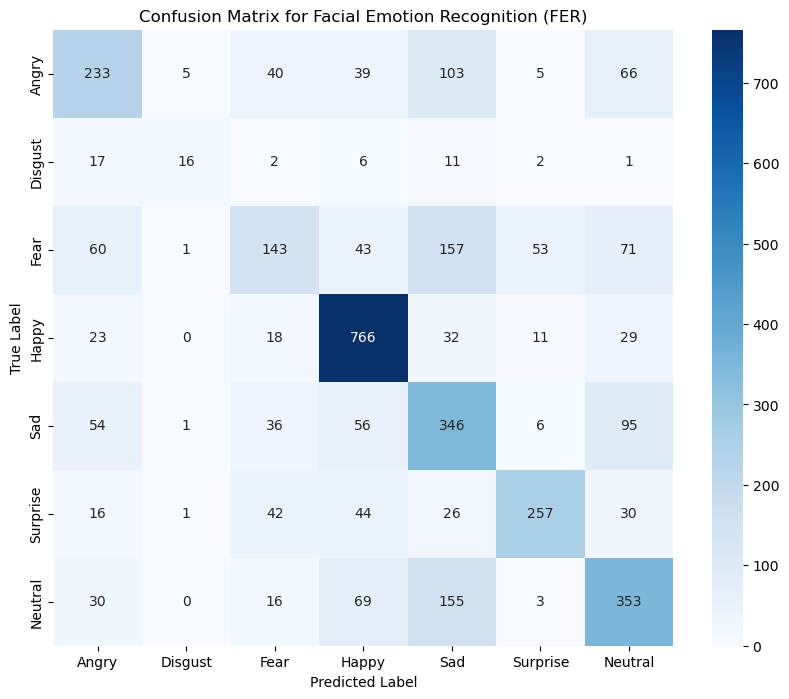


--- Performance Evaluation for Speech Emotion Recognition (SER) ---
Test Loss: 1.5592
Test Accuracy: 0.4132

Classification Report:
              precision    recall  f1-score   support

     neutral       0.33      0.45      0.38        20
        calm       0.52      0.77      0.62        44
       happy       0.32      0.21      0.25        34
         sad       0.12      0.05      0.07        39
       angry       0.60      0.29      0.39        42
     fearful       0.25      0.19      0.21        32
     disgust       0.29      0.53      0.38        32
   surprised       0.58      0.71      0.64        45

    accuracy                           0.41       288
   macro avg       0.38      0.40      0.37       288
weighted avg       0.40      0.41      0.38       288



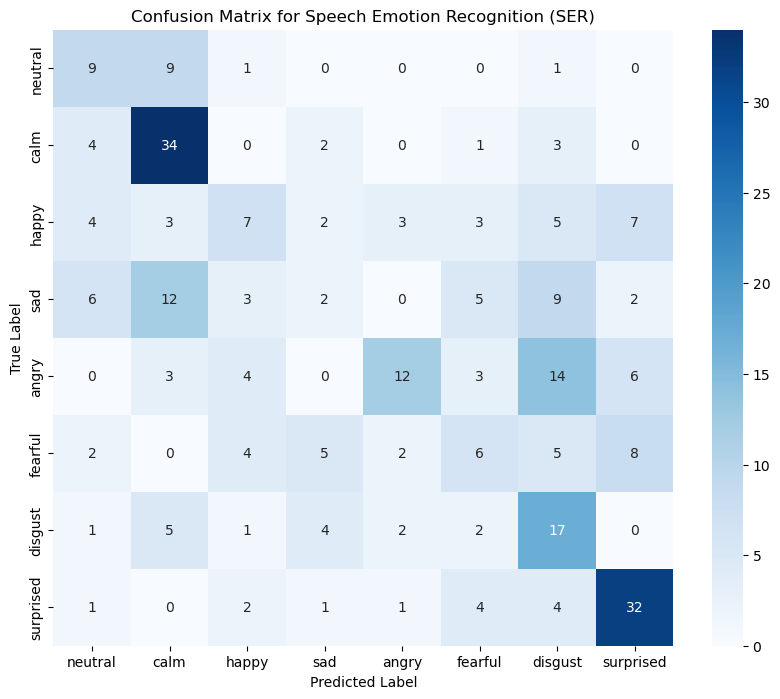

In [23]:
def evaluate_model_performance(model, X_test, y_test, emotion_labels, model_name):
    """
    Evaluates the model and reports key performance metrics.
    """
    print(f"\n--- Performance Evaluation for {model_name} ---")
    
    # 1. Predict on the test set
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # 2. Calculate Loss and Accuracy
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # 3. Classification Report (Precision, Recall, F1-score)
    report = classification_report(y_true, y_pred, target_names=list(emotion_labels.values()), zero_division=0)
    print("\nClassification Report:")
    print(report)
    
    # 4. Confusion Matrix (Visual)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=list(emotion_labels.values()), 
                yticklabels=list(emotion_labels.values()))
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return report, cm

# --- Run Evaluation ---
print("\n--- Running Model Evaluations ---")

# FER Evaluation
if len(X_test_fer) > 0:
    fer_report, fer_cm = evaluate_model_performance(fer_model, X_test_fer, y_test_fer, FER_EMOTION_LABELS, "Facial Emotion Recognition (FER)")

# SER Evaluation
if len(X_test) > 0:
    ser_report, ser_cm = evaluate_model_performance(ser_model, X_test, y_test, RAVDESS_EMOTION_LABELS, "Speech Emotion Recognition (SER)")

## 6. Command-Line Interface (CLI) Application

In [29]:
def run_cli_demo():
    
    print("  Multimodal Emotion Recognition CLI Application  ")
    
    # Load models
    try:
        fer_m = tf.keras.models.load_model('fer_model.h5')
        ser_m = tf.keras.models.load_model('ser_model.h5')
    except:
        print("WARNING: Models not found or failed to load. Using in-memory models.")
        fer_m = fer_model
        ser_m = ser_model

    # --- Simulation of real-world input ---
    print("\nSimulating input from a live video/audio stream...")
    
    # 1. Simulate Image Capture and Preprocessing
    print("1. Processing Facial Input (Simulated Frame)...")
    simulated_fer_input = np.random.rand(1, IMG_SIZE, IMG_SIZE, 1).astype('float32')
    
    # 2. Simulate Audio Capture and Feature Extraction
    print("2. Processing Speech Input (Simulated Audio Clip)...")
    simulated_ser_input = np.random.rand(1, MFCC_COUNT, MAX_PAD_LEN, 1).astype('float32')
    
    # 3. Run Multimodal Prediction
    print("3. Running Multimodal Prediction...")
    result = multimodal_predict(fer_m, ser_m, simulated_fer_input, simulated_ser_input)
    
    # 4. Display Results
    print("\n--- Final Multimodal Result ---")
    print(f"Facial Emotion: {result['facial_emotion']} (Confidence: {result['facial_confidence']:.2f})")
    print(f"Speech Emotion: {result['speech_emotion']} (Confidence: {result['speech_confidence']:.2f})")
    
    # Simple Fusion Logic for Final Output
    if result['facial_confidence'] > 0.6 and result['speech_confidence'] > 0.6 and result['facial_emotion'] == result['speech_emotion']:
        final_emotion = result['facial_emotion']
        print(f"\nFINAL DECISION (High Agreement): {final_emotion}")
    elif result['facial_confidence'] > result['speech_confidence']:
        final_emotion = result['facial_emotion']
        print(f"\nFINAL DECISION (Weighted towards Face): {final_emotion}")
    else:
        final_emotion = result['speech_emotion']
        print(f"\nFINAL DECISION (Weighted towards Speech): {final_emotion}")
        

# Execute the CLI demo
if __name__ == '__main__':
    # This block ensures the code runs when the notebook is executed as a script
    # In a typical Jupyter environment, the cells are run sequentially.
    print("Running main application logic...")
    run_cli_demo()

Running main application logic...
  Multimodal Emotion Recognition CLI Application  



Simulating input from a live video/audio stream...
1. Processing Facial Input (Simulated Frame)...
2. Processing Speech Input (Simulated Audio Clip)...
3. Running Multimodal Prediction...



--- Final Multimodal Result ---
Facial Emotion: Neutral (Confidence: 1.00)
Speech Emotion: surprised (Confidence: 0.19)

FINAL DECISION (Weighted towards Face): Neutral
